In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding
import torch.nn as nn
from transformers import AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import warnings
import random
import ast
import torch.nn.functional as F
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.model_selection import train_test_split



warnings.filterwarnings('ignore')

/home/pepe/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TOKEN_DIM = 256
PROB = 0.3
DROPOUT = 0.2  # Esto
EMBED_DIM = 768
BATCH_SIZE = 16
LR = 1e-5
WD = 1e-2
EPOCHS = 10
ACTIVATION = nn.GELU()
DATA_AUG = True  # Esto

language = "ENG"

if language == "ENG":
    MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    text_col = "translation" 
    emb_col = "embeddings_ingles" 
    par_col = "paraphrase" 
    par_emb_col_1 = "embedding_paraphrase1" 
    par_emb_col_2 = "embedding_paraphrase2" 
    TOKEN_DIM = TOKEN_DIM

else: 
    MODEL_NAME = "pysentimiento/robertuito-sentiment-analysis"
    text_col = "post content"
    emb_col = "embeddings"
    par_col = "paraphrase_esp"
    par_emb_col_1 = "embedding_paraphrase_esp1"
    par_emb_col_2 = "embedding_paraphrase_esp2"
    TOKEN_DIM = 128

In [42]:
def load_dataset(path_to_dataset):
    return pd.read_csv(path_to_dataset)

def extract_similar_descriptions(e, embeddings, k):
    similarities = cosine_similarity([e], embeddings)[0]
    top_indices = np.argsort(similarities)[-k:][::-1]
    return top_indices
    
def compute_embeddings_distance(embedding_str, k, df):
    # QUitamos del dataset la misma fila con la que estamos trabajando
    df = df[df[emb_col]!= embedding_str]

    def parse_embedding(embedding_str):
        embedding_str = embedding_str.strip("[]")
        return np.array(embedding_str.split(), dtype=np.float32)
    
    embedding = parse_embedding(embedding_str)
    df[emb_col] = df[emb_col].apply(lambda x: parse_embedding(x))

    df_pos = df[df["label"]==2]
    df_neu = df[df["label"]==1]
    df_neg = df[df["label"]==0]

    pos_description_embeddings = np.vstack(df_pos[emb_col].values)
    pos_nearest_descriptions = extract_similar_descriptions(embedding, pos_description_embeddings, k)
    pos_result = df_pos.iloc[pos_nearest_descriptions][text_col]

    neu_description_embeddings = np.vstack(df_neu[emb_col].values)
    neu_nearest_descriptions = extract_similar_descriptions(embedding, neu_description_embeddings, k)
    neu_result = df_neu.iloc[neu_nearest_descriptions][text_col]

    neg_description_embeddings = np.vstack(df_neg[emb_col].values)
    neg_nearest_descriptions = extract_similar_descriptions(embedding, neg_description_embeddings, k)
    neg_result = df_neg.iloc[neg_nearest_descriptions][text_col]
    

    return pos_result.to_list(), neu_result.to_list(), neg_result.to_list()

mapping = {"NEG":0, "NEU":1, "POS":2}

reverse_mapping = {0:"NEG", 1: "NEU", 2:"POS"}

def label2int(label):
    return mapping[label]

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

Device count: 1
Current device: 0
NVIDIA GeForce RTX 4070 Laptop GPU


In [5]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [19]:
data = load_dataset("../data/data.csv")
task_1 = load_dataset("../data/augmented_dataset_task1.csv")
task_2 = load_dataset("../data/augmented_dataset_task2.csv")

In [7]:
# train_df = load_dataset("../data/train_paraphrased.csv")
# test_df = load_dataset("../data/test_paraphrased.csv")
# val_df = load_dataset("../data/val_paraphrased.csv")
# dev_df = load_dataset("../data/dev_paraphrased.csv")
# train_df = pd.concat([train_df, dev_df]).reset_index()

train_df, test_df = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, stratify=data['label'])
# train_df, val_df = train_test_split(train_df, test_size=1/8, random_state=RANDOM_SEED, stratify=train_df['label'])

# Copy test_df to val_df
val_df = test_df.copy()

In [20]:
task_1["label"]=0
task_2["label"]=0


In [8]:
train_labels = train_df["label"]

In [9]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([0.9870, 0.5916, 3.3713], device='cuda:0')


In [21]:
class SentimentDataset(Dataset):
    def __init__(self, texts, paraphrases, labels, tokenizer, k, df, type = None, augmentation = False, local_database = train_df):
        super().__init__() 
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.k = k
        self.df = df
        self.local_database = local_database
        self.paraphrases = paraphrases
        self.type = type
        self.augmentation = augmentation

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # DATA AUG
        if self.type == "train" and self.augmentation:
            paraphrase = self.paraphrases[idx]
            samples = ast.literal_eval(paraphrase)
            samples=list(samples)
            samples.append(text)
            text = random.choice(samples)
            index = samples.index(text)


            if index == 0:
                embedding_str = self.df.loc[self.df[par_col] == paraphrase, par_emb_col_1].values[0]
            elif index == 1:
                embedding_str = self.df.loc[self.df[par_col] == paraphrase, par_emb_col_2].values[0]
            else: 
                embedding_str = self.df.loc[self.df[text_col] == text, emb_col].values[0]

            words = text.split()
            if random.random() < PROB:
            
                if len(words) > 1:
                    num_to_remove = max(1, int(0.1 * len(words)))  # Quitar ~10% de las palabras
                    indices_to_remove = random.sample(range(len(words)), num_to_remove)
                    words = [w for i, w in enumerate(words) if i not in indices_to_remove]
                    text = " ".join(words)

                if random.random() < PROB:

                    if len(words) > 1:
                        random.shuffle(words)
                        text = " ".join(words)

        else:
            embedding_str = embedding_str = self.df.loc[self.df[text_col] == text, emb_col].values[0]
        
        # Obtener los textos más similares por clase
        pos_texts, neu_texts, neg_texts = compute_embeddings_distance(embedding_str, self.k, self.local_database)
        # Tokenizar el texto principal
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")

        # Tokenizar los textos más similares
        pos_tokens = self.tokenizer(pos_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
        neu_tokens = self.tokenizer(neu_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
        neg_tokens = self.tokenizer(neg_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
        

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
            "pos_tokens": pos_tokens["input_ids"],
            "neu_tokens": neu_tokens["input_ids"],
            "neg_tokens": neg_tokens["input_ids"],
            "pos_attention": pos_tokens["attention_mask"],
            "neu_attention": neu_tokens["attention_mask"],
            "neg_attention": neg_tokens["attention_mask"],
        }

In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = SentimentDataset(
    texts=train_df[text_col].tolist(),
    labels=train_df["label"].tolist(),
    paraphrases=train_df[par_col].tolist(),
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = train_df,
    type = "train",
    augmentation=DATA_AUG
)

val_dataset = SentimentDataset(
    texts=val_df[text_col].tolist(),
    labels=val_df["label"].tolist(),
    paraphrases = [],
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = val_df
)

test_dataset = SentimentDataset(
    texts=test_df[text_col].tolist(),
    labels=test_df["label"].tolist(),
    paraphrases = [],
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = test_df
)

task_1_dataset = SentimentDataset(
    texts=task_1[text_col].tolist(),
    labels=task_1["label"].tolist(),
    paraphrases = [],
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = task_1
)

task_2_dataset = SentimentDataset(
    texts=task_2[text_col].tolist(),
    labels=task_2["label"].tolist(),
    paraphrases = [],
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = task_2
)

In [23]:
for i in range(1):
    sample = task_1_dataset[i]
    print(f"Sample {i + 1}:")
    print(f"Text: {task_1_dataset.texts[i]}")
    print(f"Label: {sample['labels'].item()}")
    print(f"Input IDs: {sample['input_ids']}")
    print(f"Attention Mask: {sample['attention_mask']}")
    print(f"Positives: {sample['pos_tokens']}")
    print(f"Neutral: {sample['neu_tokens']}")
    print(f"Negatives: {sample['neg_tokens']}")
    print(f"Positives: {sample['pos_attention']}")
    print(f"Neutral: {sample['neu_attention']}")
    print(f"Negatives: {sample['neg_attention']}")
    print("\n" + "-"*40 + "\n")

Sample 1:
Text: Demisexuality, from the English suffix demi-, "half," and the Latin sexus "sex," is a term coined by the Asexual Visibility and Education Network (AVEN) to refer to sexual attraction exclusively towards individuals with whom strong, stable, and/or lasting emotional bonds have been developed previously. Before that, a demisexual may behave like an 'asexual' and may even identify as such. Furthermore, demisexuality can refer to any type of fixation that develops into a secondary sexual attraction towards individuals with whom strong love bonds have been built, while primary sexual attraction manifests as an apparent 'asexual' orientation.
Label: 0
Input IDs: tensor([    0, 24658, 45799,  1571,     6,    31,     5,  2370, 47503,  4410,
          118, 20551,    22,  4809,    60,     8,     5,  5862,  2099,   687,
           22,  8821,    60,    16,    10,  1385, 32993,    30,     5,    83,
        28744, 10035, 12203,     8,  3061,  3658,    36, 10612,  2796,    43,
       

In [13]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    # Compute the dot products between Q and K, then scale by the square root of the key dimension
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Apply mask if provided (useful for masked self-attention in transformers)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Softmax to normalize scores, producing attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Compute the final output as weighted values
    output = torch.matmul(attention_weights, V)
    return output, attention_weights


class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.embed_size = embed_size
        # Define linear transformations for Q, K, V
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)

    def forward(self, q, k, v, mask=None):
        # Generate Q, K, V matrices
        Q = self.query(q)
        K = self.key(k)
        V = self.value(v)
        
        # Calculate attention using our scaled dot-product function
        out, _ = scaled_dot_product_attention(Q, K, V)
        return out

In [24]:
class SentimentClassifierWithMultiAttention(nn.Module):
    def __init__(self, base_model_name, num_labels=3, num_heads=3):
        super().__init__()
        
        self.bert = AutoModel.from_pretrained(base_model_name)

        """self.attention_positive = SelfAttention(EMBED_DIM)
        self.attention_negative = SelfAttention(EMBED_DIM)
        self.attention_neutral = SelfAttention(EMBED_DIM)"""

        self.attention_positive = nn.MultiheadAttention(embed_dim=EMBED_DIM, num_heads=num_heads, batch_first=True)
        self.attention_negative = nn.MultiheadAttention(embed_dim=EMBED_DIM, num_heads=num_heads, batch_first=True)
        self.attention_neutral = nn.MultiheadAttention(embed_dim=EMBED_DIM, num_heads=num_heads, batch_first=True)


        """self.linear_intermediate = nn.Linear(EMBED_DIM * 4, EMBED_DIM)
        self.activation = ACTIVATION
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(EMBED_DIM, num_labels)"""

        self.feedforward = nn.Sequential(
            nn.Linear(EMBED_DIM * 4, EMBED_DIM),
            ACTIVATION,
            nn.Dropout(DROPOUT),
            nn.Linear(EMBED_DIM, EMBED_DIM // 2),
            ACTIVATION,
            nn.Dropout(DROPOUT),
            nn.Linear(EMBED_DIM // 2, EMBED_DIM // 4),
            ACTIVATION,
            nn.Dropout(DROPOUT)
        )
        self.classifier = nn.Linear(EMBED_DIM // 4, num_labels)

    def forward(self, input_ids, attention_mask, labels=None, pos_tokens=None, neu_tokens=None, neg_tokens=None, pos_attention=None, neu_attention = None, neg_attention = None):
        
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # Token CLS
        cls_embedding_expanded = cls_embedding.unsqueeze(1)

        pos_outputs_0 = self.bert(pos_tokens[:,0,:], attention_mask=pos_attention[:,0,:])
        pos_cls_embedding_0 = pos_outputs_0.last_hidden_state[:, 0, :]
        pos_cls_embedding_0 = pos_cls_embedding_0.unsqueeze(1)  

        pos_cls_embedding = pos_cls_embedding_0

        neu_outputs_0 = self.bert(neu_tokens[:,0,:], attention_mask=neu_attention[:,0,:])
        neu_cls_embedding_0 = neu_outputs_0.last_hidden_state[:, 0, :]
        neu_cls_embedding_0 = neu_cls_embedding_0.unsqueeze(1)  

        neu_cls_embedding = neu_cls_embedding_0

        neg_outputs_0 = self.bert(neg_tokens[:,0,:], attention_mask=neg_attention[:,0,:])
        neg_cls_embedding_0 = neg_outputs_0.last_hidden_state[:, 0, :]
        neg_cls_embedding_0 = neg_cls_embedding_0.unsqueeze(1)  

        neg_cls_embedding = neg_cls_embedding_0

        cls_embedding_expanded = cls_embedding_expanded.float()
        pos_cls_embedding = pos_cls_embedding.float()
        neg_cls_embedding = neg_cls_embedding.float()
        neu_cls_embedding = neu_cls_embedding.float()

        
        """
        Cada salida (attn_pos, attn_neg, attn_neut) representa una versión contextualizada del cls_embedding 
        influenciada por los mensajes de su respectiva clase. Es decir, el embedding [CLS] de entrada ha sido 
        modificado en función de lo que "aprendió" al atender a los mensajes positivos, negativos o neutros.
        
        """

        """attn_pos = self.attention_positive(cls_embedding_expanded, pos_cls_embedding, cls_embedding_expanded)
        attn_neg = self.attention_negative(cls_embedding_expanded, neg_cls_embedding, cls_embedding_expanded)
        attn_neut = self.attention_neutral(cls_embedding_expanded, neu_cls_embedding, cls_embedding_expanded)"""

        attn_pos, _ = self.attention_positive(cls_embedding_expanded, pos_cls_embedding, cls_embedding_expanded)
        attn_neg, _ = self.attention_negative(cls_embedding_expanded, neg_cls_embedding, cls_embedding_expanded)
        attn_neut, _ = self.attention_neutral(cls_embedding_expanded, neu_cls_embedding, cls_embedding_expanded)



        """
        En este punto hemos sacado un nuevo embedding aplicando la capa de atencion del embedding entrante con los dos embeddings de cada clase siendo:
        Q = embedding entrante
        K = clase_emb
        V = embedding entrante

        Porque si V = clase_emb entonces:
        Si pasas clase_emb como V, entonces el mecanismo de atención devolverá una combinación ponderada de los embeddings de la clase POSITIVA, 
        determinada por la similitud entre cls_embedding_expanded (Q) y clase_emb (K).
        """

        combined_embedding = torch.cat([
            cls_embedding,
            attn_pos.squeeze(1),
            attn_neg.squeeze(1),
            attn_neut.squeeze(1)
        ], dim=-1)
        

        #logits = self.classifier(self.dropout(self.activation(self.linear_intermediate(combined_embedding))))
        logits = self.classifier(self.feedforward(combined_embedding))
        return logits



model = SentimentClassifierWithMultiAttention(MODEL_NAME, num_labels=3)


### Congelamos todas las capas menos la última capa de clasificación

In [15]:
# for param in list(model.bert.parameters()):
#    param.requires_grad = False

In [16]:
model.to(device)

SentimentClassifierWithMultiAttention(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
       

In [26]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

task_1_dataloader = DataLoader(task_1_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
task_2_dataloader = DataLoader(task_2_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

In [27]:
for batch in task_1_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([16, 256]),
 'attention_mask': torch.Size([16, 256]),
 'labels': torch.Size([16]),
 'pos_tokens': torch.Size([16, 1, 256]),
 'neu_tokens': torch.Size([16, 1, 256]),
 'neg_tokens': torch.Size([16, 1, 256]),
 'pos_attention': torch.Size([16, 1, 256]),
 'neu_attention': torch.Size([16, 1, 256]),
 'neg_attention': torch.Size([16, 1, 256])}

### Fine-Tuning Context Awareness Model

In [28]:
from torch.optim import AdamW

In [20]:
models_path = "../checkpoints/"

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD) #, weight_decay=WD

num_epochs = EPOCHS
num_training_steps = num_epochs * len(train_dataloader)
scheduler = MultiStepLR(optimizer, milestones=[8], gamma=0.1)


print(num_training_steps)

3610


In [21]:
from tqdm.auto import tqdm

train_losses = []
val_losses = []
lfunct = nn.CrossEntropyLoss(weight=class_weights)

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0 
    num_train_batches = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)  # Logits
        y_true = batch["labels"]
        
        loss = lfunct(outputs, y_true)

        loss.backward()

        optimizer.step()
        #scheduler.step()


        optimizer.zero_grad()
        
        # Accumulate loss
        epoch_train_loss += loss.item()
        num_train_batches += 1

        progress_bar.update(1)

    # Compute average training loss for the epoch
    avg_train_loss = epoch_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Run validation
    model.eval()
    epoch_val_loss = 0
    num_val_batches = 0

    y_preds_val = []
    y_trues_val = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            y_true = batch["labels"]

            loss = lfunct(outputs, y_true)
            epoch_val_loss += loss.item()
            num_val_batches += 1

            y_preds_val.extend(torch.argmax(outputs, dim=-1).cpu().tolist())
            y_trues_val.extend(batch["labels"].cpu().tolist())

    y_preds_val = np.array(y_preds_val)
    y_trues_val = np.array(y_trues_val)
    f1_val = f1_score(y_trues_val, y_preds_val, average='macro')

    avg_val_loss = epoch_val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs:<10} Train Loss: {avg_train_loss:<10.4f} Val Loss: {avg_val_loss:<10.4f} Macro F1: {f1_val:.4f}")

    torch.save(model.state_dict(), f"../checkpoints/{epoch + 1}_context.pth")
    #torch.save(model, f"../checkpoints/{epoch + 1}_full_context_model.pth")

 10%|█         | 361/3610 [33:38<4:01:30,  4.46s/it]

Epoch 1/10         Train Loss: 1.0331     Val Loss: 0.9585     Macro F1: 0.4751


 20%|██        | 722/3610 [1:16:05<3:41:49,  4.61s/it] 

Epoch 2/10         Train Loss: 0.9355     Val Loss: 0.9616     Macro F1: 0.4432


 30%|███       | 1083/3610 [1:58:41<3:12:40,  4.57s/it]  

Epoch 3/10         Train Loss: 0.8684     Val Loss: 0.9892     Macro F1: 0.4949


 40%|████      | 1444/3610 [2:41:15<2:45:09,  4.58s/it]   

Epoch 4/10         Train Loss: 0.7990     Val Loss: 0.9171     Macro F1: 0.5543


 50%|█████     | 1805/3610 [3:23:50<2:17:27,  4.57s/it]  

Epoch 5/10         Train Loss: 0.7316     Val Loss: 1.0224     Macro F1: 0.5490


 60%|██████    | 2166/3610 [4:06:24<1:49:58,  4.57s/it]  

Epoch 6/10         Train Loss: 0.7001     Val Loss: 0.9453     Macro F1: 0.5272


 70%|███████   | 2527/3610 [4:48:58<1:22:16,  4.56s/it]  

Epoch 7/10         Train Loss: 0.6250     Val Loss: 1.1359     Macro F1: 0.5415


 80%|████████  | 2888/3610 [5:31:31<54:58,  4.57s/it]    

Epoch 8/10         Train Loss: 0.5786     Val Loss: 1.0250     Macro F1: 0.5057


 90%|█████████ | 3249/3610 [6:14:05<27:29,  4.57s/it]    

Epoch 9/10         Train Loss: 0.5473     Val Loss: 1.2021     Macro F1: 0.5310


100%|██████████| 3610/3610 [6:56:39<00:00,  4.62s/it]    

Epoch 10/10         Train Loss: 0.5004     Val Loss: 1.3653     Macro F1: 0.5509


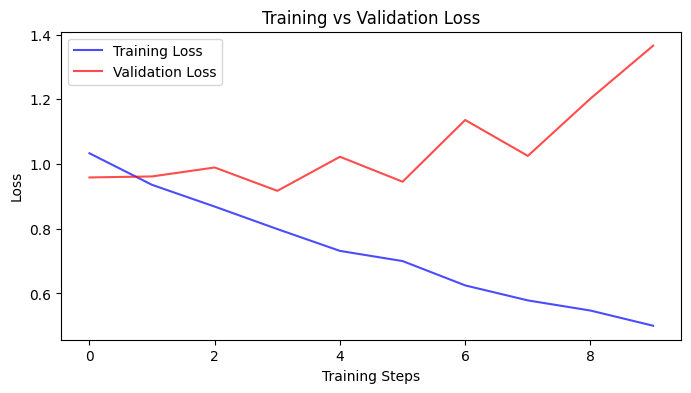

In [22]:
import matplotlib.pyplot as plt
# Plot Training vs Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss", color="blue", alpha=0.7)
plt.plot(val_losses, label="Validation Loss", color="red", alpha=0.7)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [23]:
# torch.save(model.state_dict(), "../checkpoints/context.pth")

In [24]:
# torch.save(model, "../checkpoints/full_context_model.pth")

In [29]:
state_dict = torch.load("../checkpoints/4_context.pth", map_location=torch.device(device)) 
model = SentimentClassifierWithMultiAttention(MODEL_NAME, num_labels=3)
model.load_state_dict(state_dict)
model.to(device)

SentimentClassifierWithMultiAttention(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
       

### Validation

In [38]:
model.eval()

y_pred_val = []
y_true_val = []
with torch.no_grad(): 
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_val.extend(torch.argmax(outputs, dim=-1).tolist())
        y_true_val.extend(batch["labels"].tolist())

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
print(y_pred_val.shape, y_true_val.shape)
print(classification_report(y_true_val, y_pred_val, target_names=mapping.keys()))

(1442,) (1442,)
              precision    recall  f1-score   support

         NEG       0.56      0.59      0.57       487
         NEU       0.70      0.67      0.68       812
         POS       0.39      0.41      0.40       143

    accuracy                           0.62      1442
   macro avg       0.55      0.56      0.55      1442
weighted avg       0.62      0.62      0.62      1442



### Test

In [39]:
model.eval()

y_pred_test = []
y_true_test = []
with torch.no_grad(): 
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_test.extend(torch.argmax(outputs, dim=-1).tolist())
        y_true_test.extend(batch["labels"].tolist())

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)
print(y_pred_test.shape, y_true_test.shape)
print(classification_report(y_true_test, y_pred_test, target_names=mapping.keys()))

(1442,) (1442,)
              precision    recall  f1-score   support

         NEG       0.56      0.59      0.57       487
         NEU       0.70      0.67      0.68       812
         POS       0.39      0.41      0.40       143

    accuracy                           0.62      1442
   macro avg       0.55      0.56      0.55      1442
weighted avg       0.62      0.62      0.62      1442



### TASK 1

In [30]:
model.eval()

y_pred_task_1 = []
with torch.no_grad(): 
    for batch in task_1_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_task_1.extend(torch.argmax(outputs, dim=-1).tolist())

y_pred_task_1 = np.array(y_pred_task_1)


In [69]:
aux = load_dataset("../data/translated_dataset_task1.csv")

In [70]:
ids = aux["id"]

preds_task_1 = pd.DataFrame(columns=["id", "label"])
preds_task_1["id"] = ids
preds_task_1["label"]= y_pred_task_1
preds_task_1["label"] = preds_task_1["label"].apply(lambda x: reverse_mapping[x])
preds_task_1.to_csv("../data/task1_predictions.csv")

### TASK 2

In [37]:
model.eval()

y_pred_task_2 = []
with torch.no_grad(): 
    for batch in task_2_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_task_2.extend(torch.argmax(outputs, dim=-1).tolist())

y_pred_task_2 = np.array(y_pred_task_2)

In [51]:
aux = load_dataset("../data/translated_dataset_task2.csv")

In [64]:
ids = aux["id"]

preds_task_2 = pd.DataFrame(columns=["id", "label"])

In [67]:
preds_task_2["id"] = ids
preds_task_2["label"]= y_pred_task_2
preds_task_2["label"] = preds_task_2["label"].apply(lambda x: reverse_mapping[x])


In [68]:
preds_task_2.to_csv("../data/task2_predictions.csv")

In [39]:
def predict_sample(model, tokenizer, sample_text, label, embedding_str):
    """
    Predict the sentiment of a sample text
    """

    pos_texts, neu_texts, neg_texts = compute_embeddings_distance(embedding_str, 1, train_df)
    encoding = tokenizer(sample_text, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")

    # Tokenizar los textos más similares
    pos_tokens = tokenizer(pos_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
    neu_tokens = tokenizer(neu_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
    neg_tokens = tokenizer(neg_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
    

    inputs = {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"],
        "labels": torch.tensor(label, dtype=torch.long),
        "pos_tokens": pos_tokens["input_ids"].unsqueeze(1),
        "neu_tokens": neu_tokens["input_ids"].unsqueeze(1),
        "neg_tokens": neg_tokens["input_ids"].unsqueeze(1),
        "pos_attention": pos_tokens["attention_mask"].unsqueeze(1),
        "neu_attention": neu_tokens["attention_mask"].unsqueeze(1),
        "neg_attention": neg_tokens["attention_mask"].unsqueeze(1),
    }
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs
    probabilities = torch.softmax(logits, dim=-1)
    
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    
    
    return predicted_class, probabilities[0].cpu().numpy()

In [ ]:
y_pred_test = []
y_true_test = []

for i in range(len(test_df)):
    input_text = test_df["translation"][i]
    input_label = test_df["label"][i]
    input_embedding = test_df["embeddings_ingles"][i]    
    # Get paraphrased samples
    samples = ast.literal_eval(test_df["paraphrase"][i])
    samples=list(samples)
    paraphrase_text1 = samples[0]
    paraphrase_text2 = samples[1]
    input_emb_p1 = test_df["embedding_paraphrase1"][i]
    input_emb_p2 = test_df["embedding_paraphrase2"][i]

    real_label = test_df['label'][i]

    predicted_label, probabilities = predict_sample(model, tokenizer, input_text, input_label, input_embedding)
    predicted_label1, probabilities1 = predict_sample(model, tokenizer, paraphrase_text1, input_label, input_emb_p1)
    predicted_label2, probabilities2 = predict_sample(model, tokenizer, paraphrase_text2, input_label, input_emb_p2)

    if predicted_label != predicted_label1 and predicted_label != predicted_label2 and predicted_label1 != predicted_label2:
        labels = [predicted_label, predicted_label1, predicted_label2]
        label1_score = max(probabilities)
        label2_score = max(probabilities1)
        label3_score = max(probabilities2)
        scores = {label1_score: predicted_label, label2_score: predicted_label1, label3_score: predicted_label2}
        final_label = max(scores.keys())
        predicted_label = scores[final_label]
    else:
        # Get the most frequent label
        predicted_label = max(predicted_label, predicted_label1, predicted_label2, key=[predicted_label, predicted_label1, predicted_label2].count)
        
    y_pred_test.append(predicted_label)
    y_true_test.append(real_label)

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)

              precision    recall  f1-score   support

         NEG       0.57      0.59      0.58       487
         NEU       0.71      0.69      0.70       812
         POS       0.41      0.41      0.41       143

    accuracy                           0.63      1442
   macro avg       0.56      0.56      0.56      1442
weighted avg       0.63      0.63      0.63      1442



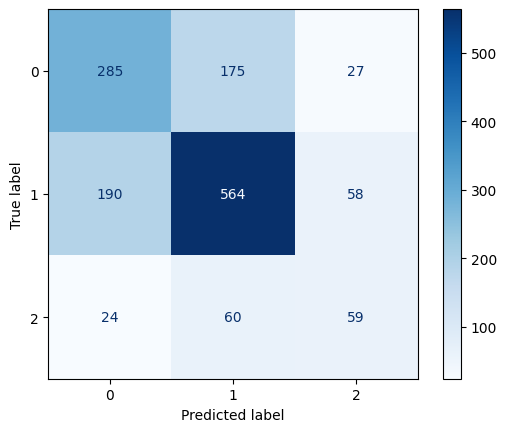

In [42]:
print(classification_report(y_true_test, y_pred_test, target_names=mapping.keys()))
# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mapping.values())
disp.plot(cmap=plt.cm.Blues)

### TASK 1

In [74]:
task_1["label"] = task_1["label"].apply(lambda x: mapping[x])

KeyError: 1

In [75]:
y_pred_ens_task_1 = []

for i in range(len(task_1)):
    input_text = task_1["translation"][i]
    input_label = task_1["label"][i]
    input_embedding = task_1["embeddings_ingles"][i]    
    # Get paraphrased samples
    samples = ast.literal_eval(task_1["paraphrase"][i])
    samples=list(samples)
    paraphrase_text1 = samples[0]
    paraphrase_text2 = samples[1]
    input_emb_p1 = task_1["embedding_paraphrase1"][i]
    input_emb_p2 = task_1["embedding_paraphrase2"][i]


    predicted_label, probabilities = predict_sample(model, tokenizer, input_text, input_label, input_embedding)
    predicted_label1, probabilities1 = predict_sample(model, tokenizer, paraphrase_text1, input_label, input_emb_p1)
    predicted_label2, probabilities2 = predict_sample(model, tokenizer, paraphrase_text2, input_label, input_emb_p2)

    if predicted_label != predicted_label1 and predicted_label != predicted_label2 and predicted_label1 != predicted_label2:
        labels = [predicted_label, predicted_label1, predicted_label2]
        label1_score = max(probabilities)
        label2_score = max(probabilities1)
        label3_score = max(probabilities2)
        scores = {label1_score: predicted_label, label2_score: predicted_label1, label3_score: predicted_label2}
        final_label = max(scores.keys())
        predicted_label = scores[final_label]
    else:
        # Get the most frequent label
        predicted_label = max(predicted_label, predicted_label1, predicted_label2, key=[predicted_label, predicted_label1, predicted_label2].count)
        
    y_pred_ens_task_1.append(predicted_label)

y_pred_ens_task_1 = np.array(y_pred_ens_task_1)

aux = load_dataset("../data/translated_dataset_task1.csv")

ids = aux["id"]

preds_task_1_ens = pd.DataFrame(columns=["id", "label"])
preds_task_1_ens["id"] = ids
preds_task_1_ens["label"]= y_pred_ens_task_1
preds_task_1_ens["label"] = preds_task_1_ens["label"].apply(lambda x: reverse_mapping[x])
preds_task_1_ens.to_csv("../data/task1_predictions.csv")

### TASK 2

In [76]:
task_2["label"] = task_2["label"].apply(lambda x: mapping[x])

In [ ]:
y_pred_ens_task_2 = []

for i in range(len(task_2)):
    input_text = task_2["translation"][i]
    input_label = task_2["label"][i]
    input_embedding = task_2["embeddings_ingles"][i]    
    # Get paraphrased samples
    samples = ast.literal_eval(task_2["paraphrase"][i])
    samples=list(samples)
    paraphrase_text1 = samples[0]
    paraphrase_text2 = samples[1]
    input_emb_p1 = task_2["embedding_paraphrase1"][i]
    input_emb_p2 = task_2["embedding_paraphrase2"][i]


    predicted_label, probabilities = predict_sample(model, tokenizer, input_text, input_label, input_embedding)
    predicted_label1, probabilities1 = predict_sample(model, tokenizer, paraphrase_text1, input_label, input_emb_p1)
    predicted_label2, probabilities2 = predict_sample(model, tokenizer, paraphrase_text2, input_label, input_emb_p2)

    if predicted_label != predicted_label1 and predicted_label != predicted_label2 and predicted_label1 != predicted_label2:
        labels = [predicted_label, predicted_label1, predicted_label2]
        label1_score = max(probabilities)
        label2_score = max(probabilities1)
        label3_score = max(probabilities2)
        scores = {label1_score: predicted_label, label2_score: predicted_label1, label3_score: predicted_label2}
        final_label = max(scores.keys())
        predicted_label = scores[final_label]
    else:
        # Get the most frequent label
        predicted_label = max(predicted_label, predicted_label1, predicted_label2, key=[predicted_label, predicted_label1, predicted_label2].count)
        
    y_pred_ens_task_2.append(predicted_label)

y_pred_ens_task_2 = np.array(y_pred_ens_task_2)

aux = load_dataset("../data/translated_dataset_task2.csv")

ids = aux["id"]

preds_task_2_ens = pd.DataFrame(columns=["id", "label"])
preds_task_2_ens["id"] = ids
preds_task_2_ens["label"]= y_pred_ens_task_2
preds_task_2_ens["label"] = preds_task_2_ens["label"].apply(lambda x: reverse_mapping[x])
preds_task_2_ens.to_csv("../data/task2_predictions.csv")